## Pearson Correlation Coefficient

If we have two vectors of the same length, $x$ and $y$, where each element of $x$ is paired with the corresponding element of $y$, **covariance** provides a measure of how related the variables are to each other:
$$ \text{cov}(x, y) = \frac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y}) }{n} $$

A drawback of covariance is that it confounds the relative scale of two variables with a measure of the variables' relatedness. **Correlation** builds on covariance and overcomes this drawback via rescaling, thereby measuring (linear) relatedness exclusively. Correlation is much more common because of this difference.

The correlation coefficient (developed by Karl Pearson in the 20th c. though known in the 19th c.) is often denoted with $r$ or $\rho$ and is defined by:
$$ \rho_{x,y} = \frac{\text{cov}(x,y)}{\sigma_x \sigma_y} $$

In [2]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [4]:
x = iris['sepal_length']
y = iris['petal_length']

sns.set_style('darkgrid')

<Axes: xlabel='sepal_length', ylabel='petal_length'>

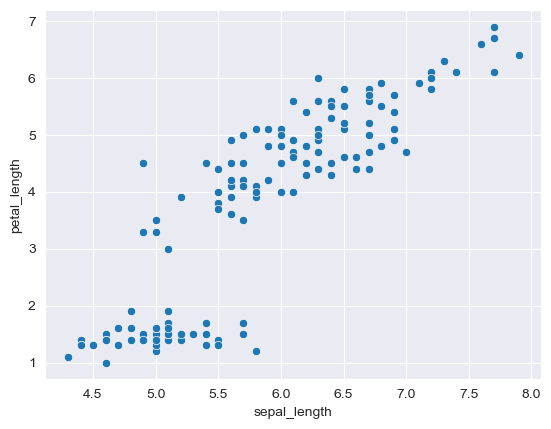

In [5]:
sns.scatterplot(x=x, y=y)

In [8]:
xbar, ybar = np.mean(x), np.mean(y)
print(xbar, ybar)

5.843333333333334 3.7580000000000005


In [9]:
n = iris.sepal_length.size

In [10]:
product = []
for i in range(n):
    product.append((x[i] - xbar) * (y[i] - ybar))
    
cov = sum(product) / n
cov

np.float64(1.2658200000000006)

In [11]:
# pearson correlation coefficient
r = cov / (np.std(x) * np.std(y))
r

np.float64(0.8717537758865835)

We reached this point in *Probability*. Now, as for how to determine a *p*-value, we first calculate the *t*-statistic...
$$ t = r \sqrt{\frac{n-2}{1-r^2}} $$

(This formula standardizes the correlation coefficient, taking into account the sample size *n* and the strength of the relationship *r*, to produce a *t*-statistic that follows [Student's *t*-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution).)

In [12]:
t = r * ((n-2)/ (1 - r**2))**0.5
t

np.float64(21.646019345759807)

Convert to p-value as we have done it several times:

In [15]:
def p_from_t(my_t, my_n):
    return 2 * st.t.cdf(-abs(my_t), my_n-1) # 2nd arg to t.cdf() is "degrees of freedom"

In [20]:
p = p_from_t(t, n-1)
p

np.float64(1.0386674194495906e-47)

In [21]:
-np.log10(p)

np.float64(46.98352349096045)

This confirms that iris sepal length's positive correlation with petal length is (extremely!) statistically significant.

All of the above can be done in a single line with SciPy's `pearsonr()` method:

In [22]:
st.pearsonr(x, y)

PearsonRResult(statistic=np.float64(0.8717537758865831), pvalue=np.float64(1.0386674194498828e-47))

And, for reference, here's a correlation that is not significant ($r \approx 0$):

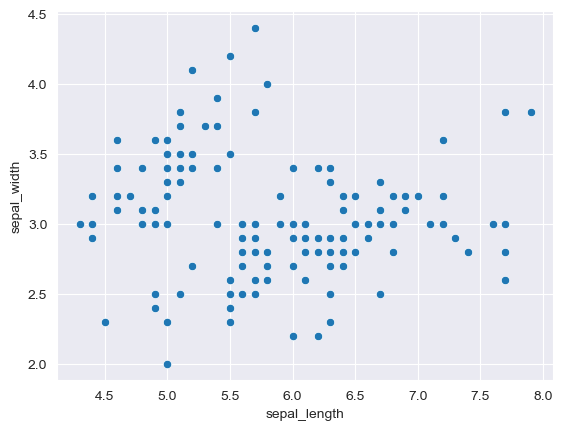

In [23]:
_ = sns.scatterplot(x=iris.sepal_length, y=iris.sepal_width)

In [24]:
st.pearsonr(iris.sepal_length, iris.sepal_width)

PearsonRResult(statistic=np.float64(-0.11756978413300204), pvalue=np.float64(0.1518982607114478))

## The Coefficient of Determination

...also known as $r^2$, this is the proportion of variance in one variable explained by another.

It can range from 0 to 1 and it is simply the square of the Pearson $r$:

In [25]:
rsq = r**2
rsq

np.float64(0.7599546457725157)

In this case, it indicates that 76% of the variance in iris petal length can be explained by sepal length. (This is easier to understand where one variable could straightforwardly drive variation in the other; more on that in Segment 2.)

For comparison, only 1.4% of the variance in sepal width can be explained by sepal length:

In [26]:
st.pearsonr(iris.sepal_length, iris.sepal_width)[0]**2

np.float64(0.013822654141080698)

## Correlation vs Causation

Correlation doesn't imply **causation** on its own. E.g., sepal length and petal length are extremely highly correlated, but this doesn't imply that sepal length causes petal length or vice versa. (Thousands of spurious correlations are provided [here](https://www.tylervigen.com/spurious-correlations) for your amusement.)

There is a lot to causality and I recommend Judea Pearl's [*Causality*](http://bayes.cs.ucla.edu/BOOK-2K/), the classic technical text on the topic, if you're keen to explore this in depth. [*The Book of Why*](http://bayes.cs.ucla.edu/WHY/) is an exceptional lay alternative by the same author.

In brief, three criteria are required for inferring causal relationships:

1. **Covariation**: Two variables vary together (this criterion is satisfied by sepal and petal length)
2. **Temporal precedence**: The affected variable must vary *after* the causal variable is varied.
3. **Elimination of extraneous variables**: We must be sure no third variable is causing the variation. This can be tricky for data we obtained through observation alone, but easier when we can control the causal variable, e.g., with (ideally double-blind) randomized control trials.

Some examples of where we could infer causality from correlation in ML:
* Additional neurons --> higher accuracy
* Additional servers or RAM --> shorter inference time
* Removal of pronouns --> less demographic bias in model

## Correcting for Multiple Comparisons

A major issue with frequentist statistics is the issue of multiple comparisons:

* If you perform 20 statistical tests where there is no real effect (i.e., the null hypothesis is true), then we would expect one of them to come up significant by chance alone (i.e., a *false positive* or *Type I error*).
* If you perform a hundred tests in such a circumstance, then you should expect five false positives.

The most straightforward, and indeed the most widely-used, solution is the **Bonferroni correction** (named after the 20th c. Italian mathematician Carlo Emilio Bonferroni). Assuming, we'd like an overall $\alpha = .05$:

* If we're planning on conducting ten tests ($m=10$), the significance threshold for each individual test is $\frac{\alpha}{m} = \frac{.05}{10} = .005$
* With 20 tests, it's $\frac{\alpha}{m} = \frac{.05}{20} = .0025$
* With 100 tests, it's $\frac{\alpha}{m} = \frac{.05}{100} = .0005$

(Other, less straightforward, approaches for adjusting $\alpha$ for multiple comparisons exist. They're beyond our scope, but the major ones are listed under the *General methods of alpha adjustment for multiple comparisons* heading [here](https://en.wikipedia.org/wiki/Multiple_comparisons_problem#See_also).)